In [0]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [54]:
from google.colab import files
upload=files.upload()

train = pd.read_csv("train_samller.csv")

Saving train_samller.csv to train_samller (1).csv


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

x_train = train.drop(labels=["label"], axis=1) 
y_train = to_categorical(train["label"], num_classes = 10)
x_train = x_train / 255.0
x_train = x_train.values.reshape(-1,28,28,1)
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

x_test.shape

(400, 28, 28, 1)

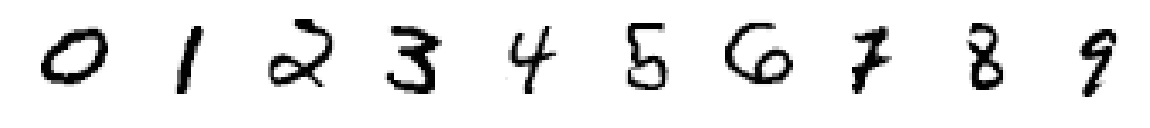

In [61]:
def sample_img_from_each_class():
    img_indices = [None]*10
    img_found = 0
    while img_found < 10:
        img_idx = np.random.randint(0, len(y_train))
        img_class = np.argmax(y_train[img_idx])
        if img_indices[img_class] is None:
            img_indices[img_class] = img_idx
            img_found += 1
    return img_indices


sample_image_indices = sample_img_from_each_class()


def display_sample_imgs(images):
    num_imgs = len(sample_image_indices)
    fig = plt.figure(figsize=(2*num_imgs, 2),facecolor='w', edgecolor='k')
    for i,img_idx in enumerate(sample_image_indices):
        img = images[img_idx]
        fig.add_subplot(1,num_imgs,i+1)
        plt.imshow(img[:,:,0], cmap='Greys',  interpolation='nearest')
        plt.axis('off')

        
display_sample_imgs(x_train)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


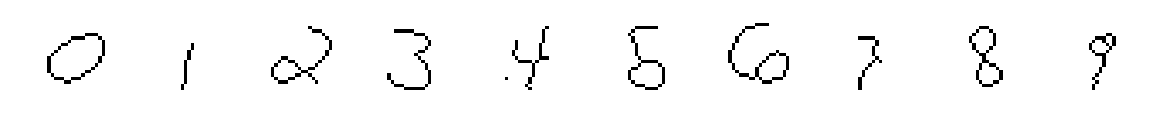

In [62]:
from skimage.morphology import skeletonize_3d

x_train_skeleton = np.array([skeletonize_3d(img) for img in x_train])
x_test_skeleton = np.array([skeletonize_3d(img) for img in x_test])

display_sample_imgs(x_train_skeleton)

In [0]:
def is_visited(coord,visited_mat):
    return visited_mat[coord[0],coord[1]] > 0


def angle_between(c1,c2):
    return math.atan2(c1[0]-c2[0], c1[1]-c2[1])


def angle_diff(a1,a2):
    return np.pi - abs(abs(a1 - a2) - np.pi)


def same_corner(c1,c2):
    return (c1[0] == c2[0] and abs(c1[1] - c2[1]) == 1) or (c1[1] == c2[1] and abs(c1[0] - c2[0]) == 1)


def coord_in_bounds(coord, bounds): # assuming bounds is shape (starting at 0)
    return coord[0] < bounds[0] and coord[1] < bounds[1] and coord[0] >= 0 and coord[1] >= 0


def line_present_at(coord,mat,thresh=1):
    return coord_in_bounds(coord,mat.shape) and mat[coord[0],coord[1]] >= thresh


def corners_from(coord):
    return [(coord[0]-1,coord[1]-1),(coord[0]+1,coord[1]-1),(coord[0]-1,coord[1]+1),(coord[0]+1,coord[1]+1)] 


def next_door_from(coord):
    return [(coord[0]-1,coord[1]),(coord[0]+1,coord[1]),(coord[0],coord[1]-1),(coord[0],coord[1]+1)] 


def all_neighbors_from(coord):
    return next_door_from(coord) + corners_from(coord)


def all_present_neighbors_from(coord,mat):
    present_neighbors = []
    for nd in all_neighbors_from(coord):
        if line_present_at(nd,mat):
            present_neighbors.append(nd)
    return present_neighbors


def angle_avg(last,new):
    weight_last = 1.0
    weight_new = 1.0
    return math.atan2((math.sin(last)*weight_last + math.sin(new)*weight_new) , (math.cos(last)*weight_last + math.cos(new)*weight_new))


def stroke_starting_points(stroke_pts):
    starting_coords = []
    first_coord = None
    last_coord = None
    for x in range(stroke_pts.shape[1]):
        for y in range(stroke_pts.shape[0]):
            if stroke_pts[y,x] <= 0: 
                continue
            if first_coord is None:
                first_coord = (y,x)
            last_coord = (y,x)
            nb_coords = all_present_neighbors_from(last_coord,stroke_pts)

            if len(nb_coords) == 1:
                starting_coords.append((y,x))
            elif len(nb_coords) == 2 and same_corner(nb_coords[0],nb_coords[1]):
                starting_coords.append((y,x))

    # when no good starting points are found, try bottom-left and top-right pixels
    if len(starting_coords) == 0:
        starting_coords = [first_coord, last_coord]

    return starting_coords


def split_stroke_at(stroke,split_coord):
    res = [[],[]]
    index = 0
    for c in stroke:
        if c == split_coord:
            index += 1
            continue
        res[index].append(c)
    return res


def best_fit_angle(Y, X):
    if len(set(Y)) == 1: # horizontal line
        slope = 0 
    elif len(set(X)) == 1: # vertial line
        slope = 10e12 
    else:
        xbar = sum(X)/len(X)
        ybar = sum(Y)/len(Y)
        n = len(X) 

        numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
        denum = sum([xi**2 for xi in X]) - n * xbar**2

        slope = numer / (denum + (0.000000001))

    return angle_between((1.0,slope),(0,0))


PRE_POST = 1
PRE_STROKE = 2
POST_STROKE = 3
def most_similar(pre,post,stroke):
    if min(len(pre),len(post),len(stroke)) <= 3:
        return PRE_POST 
    depth = -7
    pre_angle = best_fit_angle(*list(zip(*pre[depth:])))
    post_angle = best_fit_angle(*list(zip(*post[depth:])))
    stroke_angle = best_fit_angle(*list(zip(*stroke[depth:])))
    pre_post_diff = angle_diff(pre_angle,post_angle)
    pre_stroke_diff = angle_diff(pre_angle,stroke_angle)
    post_stroke_diff = angle_diff(post_angle, stroke_angle)
    min_diff = min(pre_post_diff, pre_stroke_diff, post_stroke_diff)
    if min_diff == pre_post_diff:
        return PRE_POST
    if min_diff == pre_stroke_diff:
        return PRE_STROKE
    return POST_STROKE


def get_strokes(stroke_pts):
    res_img = stroke_pts
    remaining_px = res_img.copy()
    visited = np.zeros(res_img.shape)
    strokes = []
    last_start_coords = []
    while len(remaining_px[np.where(remaining_px > 0)]) > 2:
        start_coords = stroke_starting_points(remaining_px)
        if last_start_coords == start_coords:
            break
        last_start_coords = start_coords
        for i,sc in enumerate(start_coords):
            if visited[sc] > 0:
                continue # aleady been here!
            sc_strokes = []
            stroke_id = len(strokes) + 1
            for sc_neighbor in all_present_neighbors_from(sc,res_img):
                cur = sc
                angle = angle_between(cur,sc_neighbor)
                stroke = []
                while True:
                    best_angle_diff = np.pi / 2
                    visited[cur] = stroke_id
                    remaining_px[cur] = 0
                    stroke.append(cur)
                    nxt_coord = None
                    nxt_angle = None
                    for nb in all_present_neighbors_from(cur,res_img):
                        test_angle = angle_between(cur,nb)
                        test_angle_diff = angle_diff(angle,test_angle)
                        if test_angle_diff <= best_angle_diff:
                            best_angle_diff = test_angle_diff
                            nxt_coord = nb
                            nxt_angle = test_angle
                    if nxt_coord is None: 
                        break
                    if visited[nxt_coord] > 0:
                        stroke_overlapping = int(visited[nxt_coord]) # keep track of which stroke has the contested coord
                        # CONFLICT RESOLUTION:
                        if stroke_id != stroke_overlapping:
                            stroke_index = stroke_overlapping-1
                            pre,post = split_stroke_at(strokes[stroke_index],nxt_coord)
                            post = post[::-1]
                            combine = most_similar(pre,post,stroke)
                            if combine == POST_STROKE:
                                strokes[stroke_index] = pre 
                                stroke = stroke + [nxt_coord] + post[::-1]
                            elif combine == PRE_STROKE: 
                                strokes[stroke_index] = post 
                                stroke = stroke + [nxt_coord] + pre[::-1]
                            # do nothing for PRE_POST
                        break
                    cur = nxt_coord
                    angle = angle_avg(angle,nxt_angle)
                         
                if len(stroke) > 2:
                    sc_strokes.append(stroke)
                else:
                    for coord in stroke:
                        visited[coord] = 0

            if len(sc_strokes) == 1:
                strokes.append(sc_strokes[0])
            elif len(sc_strokes) == 2:
                combined_stroke = sc_strokes[1][::-1][:-1] + sc_strokes[0]
                strokes.append(combined_stroke)
            elif len(sc_strokes) > 2:
                print('UNEXPECTED NUMBER OF STARTING POINTS FROM SINGLE STARTING POINT')
                exit()

    return strokes


def log_coords(coords, base_img):
    num_imgs = 1 + len(coords)
    fig = plt.figure(figsize=(2*num_imgs, 2),facecolor='w', edgecolor='k')
    
    o = fig.add_subplot(1,num_imgs,1)
    o.set_title('Original')
    plt.imshow(base_img[:,:,0], cmap='Greys',  interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

    for i,st in enumerate(coords):
        coord_img = base_img * 0
        for s_coord in st:
            coord_img[s_coord[0],s_coord[1]] = 255
        s = fig.add_subplot(1,num_imgs,i+2)
        s.set_title('Stroke '+str(i+1))
        plt.imshow(coord_img[:,:,0], cmap='Greys',  interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [0]:
x_train_strokes = [get_strokes(img_skeleton) for img_skeleton in x_train_skeleton]
x_test_strokes = [get_strokes(img_skeleton) for img_skeleton in x_test_skeleton]

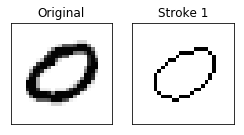

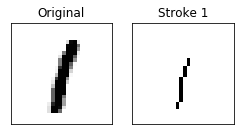

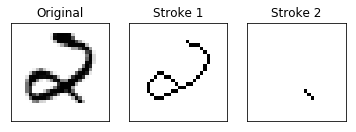

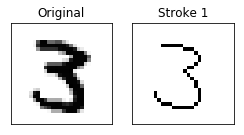

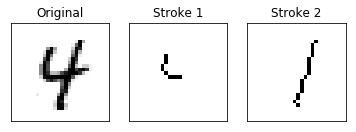

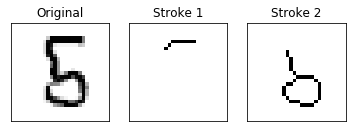

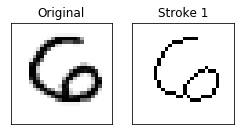

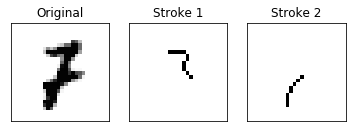

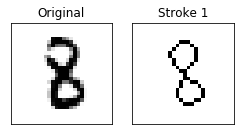

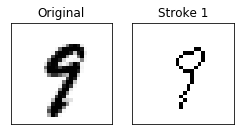

In [65]:
for i,img_idx in enumerate(sample_image_indices):
    log_coords(x_train_strokes[img_idx],x_train[img_idx])

In [0]:
!pip install -q scikit-learn

In [0]:
from rdp import rdp

def simplify_strokes(strokes,epsilon):
    simplified = []
    for stroke in strokes:
        if len(stroke) > 1:
            simplified.append(rdp(stroke,epsilon=epsilon))
    return simplified

x_train_simple_strokes = [simplify_strokes(img_strokes, 0.15) for img_strokes in x_train_strokes]
x_test_simple_strokes = [simplify_strokes(img_strokes, 0.15) for img_strokes in x_test_strokes]

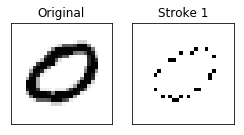

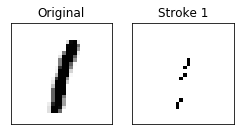

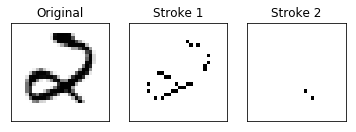

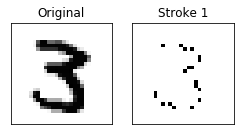

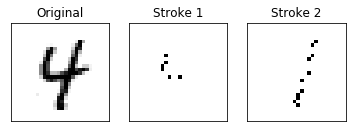

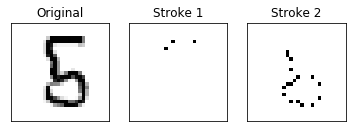

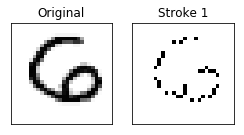

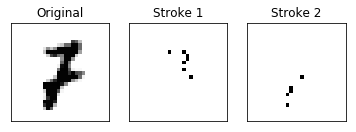

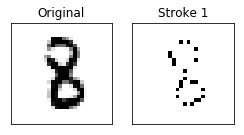

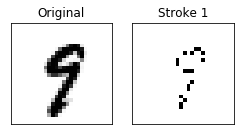

In [67]:
for i,img_idx in enumerate(sample_image_indices):
    log_coords(x_train_simple_strokes[img_idx],x_train[img_idx])

In [68]:
def flat_relative_paths(strokes):
    res = []
    pos = (0,0)
    for stroke in strokes:
        is_new_stroke = 1
        for coord in stroke:
            delta_x = coord[0] - pos[0]
            delta_y = coord[1] - pos[1]
            res.append([is_new_stroke, delta_x, delta_y])
            pos = coord
            is_new_stroke = 0
    return np.array(res)
            
    
x_train_flat_rel = [flat_relative_paths(simple_strokes) for simple_strokes in x_train_simple_strokes]
x_test_flat_rel = [flat_relative_paths(simple_strokes) for simple_strokes in x_test_simple_strokes]

print('Representation of  our sample "8"')
print('Absolute Stroke Coords:\n',x_train_simple_strokes[sample_image_indices[7]])
print('\n','-'*30,'\n')
print('Flat Relative Stroke Coords:\n',x_train_flat_rel[sample_image_indices[7]])

Representation of  our sample "7"
Absolute Stroke Coords:
 [[[8, 11], [8, 15], [9, 16], [10, 16], [11, 15], [13, 15], [15, 17]], [[23, 11], [20, 11], [19, 12], [18, 12], [15, 15]]]

 ------------------------------ 

Flat Relative Stroke Coords:
 [[ 1  8 11]
 [ 0  0  4]
 [ 0  1  1]
 [ 0  1  0]
 [ 0  1 -1]
 [ 0  2  0]
 [ 0  2  2]
 [ 1  8 -6]
 [ 0 -3  0]
 [ 0 -1  1]
 [ 0 -1  0]
 [ 0 -3  3]]


In [69]:
from keras.preprocessing import sequence

max_len = max([len(seq) for seq in x_train_flat_rel])
x_train_padded = sequence.pad_sequences(x_train_flat_rel, maxlen=max_len)

print('Longest Sequence Length:', max_len)
print('Original Image Representation:', 28*28, 'integers')
print('Stroke Path Representation:   ', 3*max_len, 'integers')

Longest Sequence Length: 39
Original Image Representation: 784 integers
Stroke Path Representation:    117 integers


In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.callbacks import LearningRateScheduler


model = Sequential()
model.add(Conv1D(48, kernel_size=(5), padding='same', input_shape=(max_len,3)))
model.add(Conv1D(64, kernel_size=(4), padding='same'))
model.add(Conv1D(96, kernel_size=(3), padding='same'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def step_decay(epoch):
    lrate = 0.001
    if epoch > 16:
        lrate = 0.0005
    if epoch > 32:
        lrate = 0.0001
    if epoch > 45:
        lrate = 0.00005
    return lrate

lrate = LearningRateScheduler(step_decay)


USE_VALIDATION = False
EPOCHS = 16 # Reduced for Kaggle, for best results use ~50 epochs
if USE_VALIDATION:
    x_train_fin, x_val, y_train_fin, y_val = train_test_split(x_train_padded, y_train, test_size=0.2, random_state=42)
    model.fit(x_train_fin, y_train_fin, batch_size=256, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[lrate])
else:
    model.fit(x_train_padded, y_train, batch_size=256, epochs=EPOCHS, callbacks=[lrate])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 39, 48)            768       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39, 64)            12352     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 39, 96)            18528     
_________________________________________________________________
dropout_3 (Dropout)          (None, 39, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 39, 128)           115200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
__________

In [0]:
def generate_prediction_file(model,test_data):
    pred = model.predict(test_data)
    pred = np.argmax(pred, axis=1)
    pred_series = pd.Series(pred,name="Label")
    submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), pred_series], axis=1)
    submission.to_csv("C:\\lstm_submission.csv", index=False)



In [0]:
padded_test_data = sequence.pad_sequences(x_test_flat_rel, maxlen=max_len)
generate_prediction_file(model, padded_test_data)

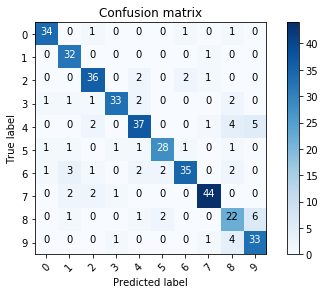

In [74]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

padded_test_data = sequence.pad_sequences(x_test_flat_rel, maxlen=max_len)
pred = model.predict(padded_test_data)
pred = np.argmax(pred, axis=1)
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))
